In [48]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import json
import csv
import re
from sklearn.preprocessing import OneHotEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this tutorial, we will test run PRINT/seq2PRINT on bulk ATAC samples. In bulk ATAC-seq, you typically will have separate fragments files for each sample (in contrast to single-cell, where there is a single framents file with barcode labels corresponding to single cells). We recommend you use scPrinter to simply load each individual fragments file together as shown below. In the individual fragments file, each line of the barcode column populated with the name of the sample. Therefore, we are essentially treating each bulk sample as a "big cell". 

The dataset is a simulated bulk ATAC dataset by sampling from the 10x PBMC 5k single cell dataset. This is to help you compare and contrast with our scATAC tutorial which uses the same dataset. We similuate 2 bulk ATAC samples from each major cell type (B cell, monocyte, T cell). Although this dataset is simulated bulk-ATAC, the data format and how we run scPrinter is exactly the same as real bulk ATAC data. 

In [2]:
main_dir = '/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial/'
work_dir = f'{main_dir}/seq2print'
if not os.path.exists(work_dir):
    os.system("mkdir -p " + work_dir)
frag_dir = f'{main_dir}/fragments'

In [ ]:
# Download the fragments files of bulk samples from our Zenodo repository https://zenodo.org/records/14866808 using the code below
samples = ["Bcell_0", "Bcell_1", "Monocyte_0", "Monocyte_1", "Tcell_0", "Tcell_1"]
for sample in samples:
    link_prefix = "https://zenodo.org/records/14866808/files/PBMC_bulk_ATAC_tutorial_"
    link_suffix = "_frags.tsv.gz?download=1"
    os.system(f"wget -O {frag_dir}/{sample}_frags.tsv.gz {link_prefix}{sample}{link_suffix}")

In [3]:
# Get the fragments files for individual samples
# Note: the fragments files should have 4 columns: chromosome, start, end, and barcode. 
# Barcode should just be sample name, which means all fragments in the same fragments file have the same barcode.
frag_files = os.listdir(frag_dir)
frag_files = [i for i in frag_files if re.search("frags.tsv.gz", i) is not None]
frag_files = sorted([os.path.join(frag_dir, i) for i in frag_files])
samples = ["_".join(re.split("[/_\\.]", i)[11:13]) for i in frag_files]
samples

['Bcell_0', 'Bcell_1', 'Monocyte_0', 'Monocyte_1', 'Tcell_0', 'Tcell_1']

## Create scprinter & preprocessing

In [4]:
printer = scp.pp.import_fragments(
                        path_to_frags=frag_files,
                        barcodes=[None] * len(frag_files), # This loads individual fragments files and combine them
                        savename=os.path.join(work_dir, 'PBMC_bulkATAC_scprinter.h5ad'),
                        genome=scp.genome.hg38,
                        min_num_fragments=1000, min_tsse=7,
                        sorted_by_barcode=False, 
                        low_memory=False,
                        )

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False


Importing fragments:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0005955448951918777, shift detected
Minimum MSE is 0.0006030499324759502, shift detected
detected plus_shift and minus_shift are 4 -5 for /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Bcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0006028001861080011, shift detected
Minimum MSE is 0.0006623381912235417, shift detected
detected plus_shift and minus_shift are 4 -5 for /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Bcell_1_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00014615018925039585, shift detected
Minimum MSE is 0.00012077646791016112, shift detected
det

  0%|          | 0/6 [00:00<?, ?it/s]

start transferring insertions


In [5]:
# Rename barcodes to sample IDs
printer.insertion_file.obs_names = samples

In [6]:
# Generate Tn5 insertion bigwigs for each pseudobulk
scp.pp.sync_footprints(printer,
                       [[sample] for sample in samples],
                       samples)

Loading insertion profiles
Creating bigwig for Bcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Bcell_1


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Monocyte_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Monocyte_1


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Tcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

Creating bigwig for Tcell_1


  0%|          | 0/24 [00:00<?, ?it/s]

## Call peaks on the fragments in a preset for training seq2PRINT model

In [16]:
# Call peaks
scp.pp.call_peaks(printer=printer,
                  frag_file=frag_files,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'],
                  preset='seq2PRINT')

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed', 
                     sep='\t', header=False, index=False)
cleaned_peaks.to_csv(f'{work_dir}/regions.bed', 
                     sep='\t', header=False, index=False)

INFO  @ Mon, 10 Feb 2025 21:41:35: 
# Command line: callpeak --nomodel -t /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Bcell_0_frags.tsv.gz /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Bcell_1_frags.tsv.gz /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Monocyte_0_frags.tsv.gz /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Monocyte_1_frags.tsv.gz /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Tcell_0_frags.tsv.gz /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//fragments/Tcell_1_frags.tsv.gz --outdir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/PBMC_bulkATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
# ARGUMENTS LIST:
# name = all
# format = BEDPE
# ChIP-seq file = ['/data/mhorlbec/250204_scPrinter_tutorial/PBMC_b

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 299137 peaks unresolved 295927 peaks selected
round: 2 146 peaks unresolved 142 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_488059/1907163871.py:9: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])


## Training separate seq2PRINT models for each sample

In [17]:
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
for sample in samples:
    # For exploratory analyses we run only one fold. For publication results you can run all 5 fold for slight improvement in accuracy.
    # If you want to run all five folds, add a for-loop layer "for fold in range(5)". This way each sample will have 5 models trained.
    fold=0 
    model_config= scp.tl.seq_model_config(printer,
                                     region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                     cell_grouping=[sample],
                                     group_names=sample,
                                     genome=printer.genome,
                                     fold=fold, 
                                     overwrite_bigwig=False,
                                     model_name='PBMC_bulkATAC_' + sample,
                                     additional_config={
                                        "notes": "v3",
                                        "tags": ["PBMC_bulkATAC", sample, 
                                            f"fold{fold}"]},
                                     path_swap=(work_dir, ''),
                                     config_save_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON')
    model_configs.append(model_config)

bigwig for Bcell_0 already exists, skip
bigwig for Bcell_1 already exists, skip
bigwig for Monocyte_0 already exists, skip
bigwig for Monocyte_1 already exists, skip
bigwig for Tcell_0 already exists, skip
bigwig for Tcell_1 already exists, skip


Below we generate the commands to run in the terminal to launch our training process (copy the generated command into a terminal and run). Before launching the training process, it is recommended to install wandb and use it to track the training process. You can first register an account on https://wandb.ai/, then you can activate your mamba/conda environment such as mamba activate scprinter, and install wandb using mamba install wandb. Then you can login via wandb login. This will connect your mamba/conda env with your wandb account. More information on wandb can be found in their quick start guide at https://docs.wandb.ai/quickstart/

Before running the generated commands, you can run nvtop first to check which GPUs are available. This is especially important when you share the same server with other users. The training job is rather computational intensive and usually one job could take a whole GPU. Therefore, we recommend you manually set the CUDA_VISIBLE_DEVICES in the commands to the fully free GPUs.

When you run the command in the terminal, make sure you are in the scprinter mamba environment. To run multiple training jobs in parallel you can add & to the end of each command, such as ```CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/configs/PBMC_bulkATAC_Bcell_0_fold0.JSON --temp_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/temp --model_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model --data_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb &```

In [18]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))

for sample in samples:
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON',
                            temp_dir=f'{work_dir}/temp',
                            model_dir=f'{work_dir}/model',
                            data_dir=work_dir,
                            gpus=samples.index(sample),
                            wandb_project='scPrinter_seq_PBMC_bulkATAC', # wandb helps you manage loggins
                            verbose=False,
                            launch=False # launch=True, this command would launch the scripts directly,
                            # otherwise, it will just display the commands, you should copy them and run them.
                           )

CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/configs/PBMC_bulkATAC_Bcell_0_fold0.JSON --temp_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/temp --model_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model --data_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/configs/PBMC_bulkATAC_Bcell_1_fold0.JSON --temp_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/temp --model_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model --data_dir /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print --project scPrinter_seq_PBMC_bulkATAC --enable_wandb
CUDA_VISIBLE_DEVICES=2 seq

## Generate TF binding scores for each sample

In [204]:
# Now fetch models:
import wandb

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'yanhu0196-harvard-university'  # Replace with your W&B entity (username or team name)
project = 'scPrinter_seq_PBMC_bulkATAC'  # Replace with your W&B project name

# Initialize the API
api = wandb.Api()

# Get the project
runs = api.runs(f"{entity}/{project}")

pretrain_models = []
model_path_dict = {}
for run in runs:
    if run.state != 'finished':
        continue
    if 'PBMC_bulkATAC' in run.tags:
        sample = [i for i in run.tags if i in samples][0]
        model_name = run.config['savename'] + '-' + run.name + '.pt'
        model_path = os.path.join(work_dir, "model", model_name)
        model_path_dict[sample] = model_path

In [28]:
regions_dict = {
    'chr11:47378230-47379030': 'SPI1', # Highly expressed in monocytes and B cells
    'chr5:140633035-140633835': 'CD14', # Monocyte marker
    'chr19:41876833-41877633': 'CD79a', # B cell marker
    'chr11:118342294-118343094': 'CD3D', # T cell marker
    'chr17:58281312-58282112': 'MPO', # Monocyte marker
    'chr16:31259594-31260394': 'ITGAM', # Expressed in myeloid cells (including monocyte)
    'chr3:39281281-39282081': 'CX3CR1', # A pretty important gene driving disease-related monocyte cell states
    'chr9:37033951-37034751': 'PAX5' # B cell marker
}

# Save example regions to a bed file
regions_df = []
for region in regions_dict:
    regions_df.append(re.split("[:-]", region))
regions_df = pd.DataFrame(regions_df)
regions_df.to_csv(f'{work_dir}/regions_test.bed',
                  sep='\t', header=False, index=False)

Below we launch the compute for TF binding scores. When we are only testing on a small number of regions or samples, we can set return_adata to be True so that the results can be returned also in an anndata object. If the number of regions or samples is big please set it to False so it doesn't take up all the memory.

Remember to check nvtop to select available GPUs using the "gpus" argument.

In [22]:
import json
adata_tfbs = {}
for sample_ind, sample in enumerate(samples):
    adata_tfbs[sample] = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_test.bed',
                          gpus=[1,2,3],
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=True,
                          post_normalize=True,
                          save_key=f'PBMC_bulkATAC_{sample}', # and input a save_key
                          save_path=work_dir)

seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3769.60it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz


working on : 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz
[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3826.92it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz


working on : 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt_PBMC_bulkATAC_Bcell_0/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt_PBMC_bulkATAC_Bcell_0/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --save_name /data/mhorlbec/250204_scPrinter_tut

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_1 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3801.10it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_1 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2

fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3932.16it/s]


[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt_PBMC_bulkATAC_Bcell_1/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt_PBMC_bulkATAC_Bcell_1/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --save_name /data/mhorlbec/250204_scPrinter_tutorial/PBMC_b

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3768.09it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3912.19it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt_PBMC_bulkATAC_Monocyte_0/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt_PBMC_bulkATAC_Monocyte_0/attr.just_sum.shap_hypo_0-30_.0.

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_1 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3915.84it/s]


[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz


working on : 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_1 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.13

fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3876.04it/s]


[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt_PBMC_bulkATAC_Monocyte_1/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tuto

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_0 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3986.56it/s]


[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_0 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3620.98it/s]


[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt_PBMC_bulkATAC_Tcell_0/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt_PBMC_bulkATAC_Tcell_0/attr.just_sum.shap_hypo_0-30_.0.85.npz -

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1 --overwrite  --write_numpy  --model_norm count --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3918.69it/s]


[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.3-6.
hypo.count.shap_hypo_0_.0.85.3-6.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.6-9.
hypo.count.shap_hypo_0_.0.85.6-9.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-3.
hypo.count.shap_hypo_0_.0.85.0-3.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 1 2 3 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_1 --overwrite  --write_numpy  --model_norm footprint --silent 
[[None]]
[1, 2, 3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
val

fetching coverage: 100%|██████████| 9/9 [00:00<00:00, 3917.06it/s]


[[None]]
[1]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[2]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9
[[None]]
[3]
signal_window 1000 dna_len 1840
input summits 9
valid summits after trimming edges 9
(9, 1)
coverage min max 891.96387 960.1363
valid summits after min/max count filter 9


working on : 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-3.
hypo.just_sum.shap_hypo_0-30_.0.85.0-3.npz


working on : 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.6-9.
hypo.just_sum.shap_hypo_0-30_.0.85.6-9.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.3-6.
hypo.just_sum.shap_hypo_0-30_.0.85.3-6.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt_PBMC_bulkATAC_Tcell_1/attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt_PBMC_bulkATAC_Tcell_1/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome 

  0%|          | 0/9 [00:00<?, ?it/s]


(1, 9, 800)
obs=groups, var=regions


Below you can see that seq2PRINT can predict cell-type-specific TF binding consistent with known biology

chr11:47378230-47379030 SPI1


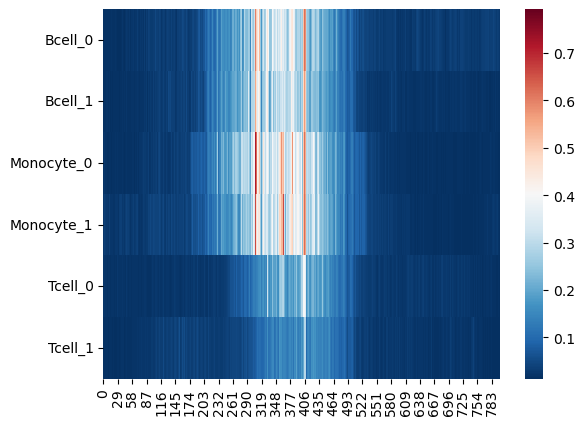

chr5:140633035-140633835 CD14


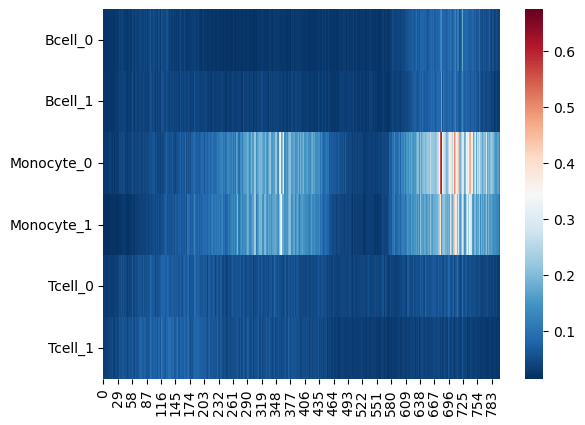

chr19:41876833-41877633 CD79a


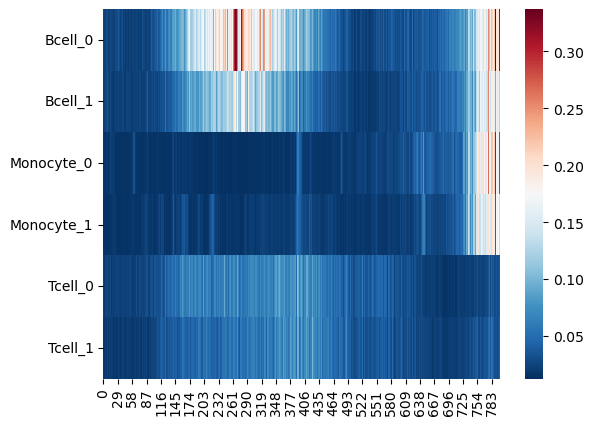

chr11:118342294-118343094 CD3D


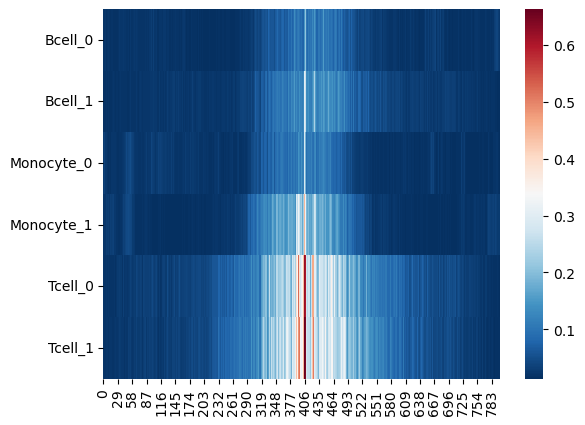

chr17:58281312-58282112 MPO


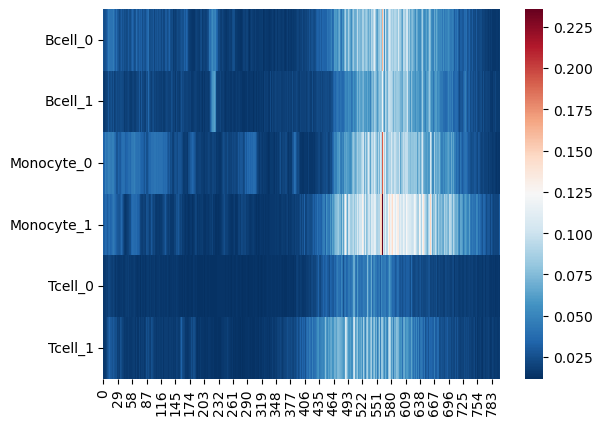

chr16:31259594-31260394 ITGAM


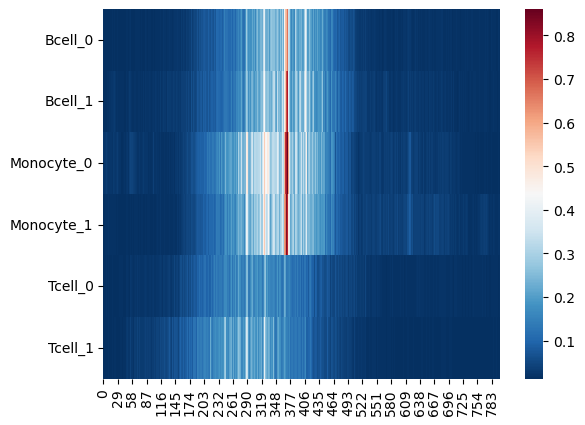

chr3:39281281-39282081 CX3CR1


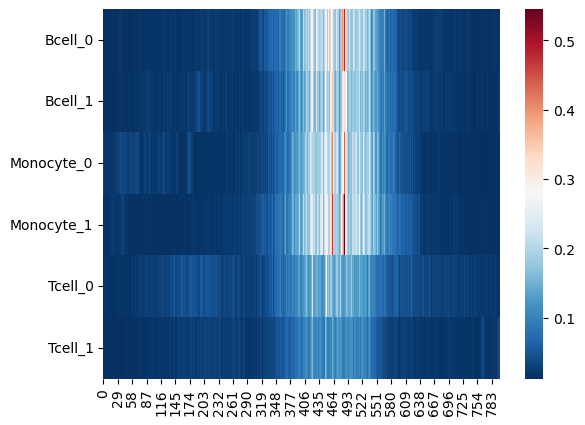

chr9:37033951-37034751 PAX5


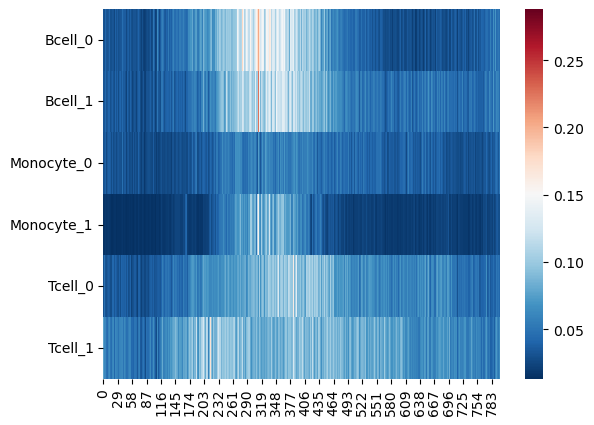

In [29]:
if not os.path.exists(f'{work_dir}/plots'):
    os.system(f'mkdir {work_dir}/plots')
for region in regions_dict.keys():
    print(region, regions_dict[region])
    tfbs = pd.DataFrame(np.array([adata_tfbs[sample].obsm[region] for sample in samples]).squeeze(), index=samples)
    sns.heatmap(tfbs, cmap='RdBu_r')
    plt.savefig(f'{work_dir}/plots/TFBS_{region}.png')
    plt.show()

### Compute TF binding scores on a larger number of peaks

When we run TF binding score calculation on a large number of peaks, we set return_adata=False and instead save the results only to bigwig files. 

We first filter peaks by depth so we remove low coverage peaks and also reduce the computational load

In [34]:
# First construct a peak-by-cell matrix of ATAC counts
peak_path = f'{work_dir}/regions.bed'
adata = scp.pp.make_peak_matrix(printer,
                       regions=peak_path,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)
adata.write(f'{work_dir}/cell_peak.h5ad')

Making peak matrix:   0%|          | 0/296069 [00:00<?, ?it/s]

In [36]:
# Remove regions with low coverage (helps to reduce total peak number and save time. The full list of 300k peaks contains many very weak peaks)
regions = pd.read_csv(f'{work_dir}/regions.bed', sep='\t', header=None)
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
peak_depth = np.array(np.sum(adata.X, axis=0)).squeeze()
regions_filt = regions.iloc[np.where(peak_depth > 200)[0], :]
regions_filt.to_csv(f'{work_dir}/regions_filt.bed', 
                     sep='\t', header=False, index=False)

Now compute TF binding scores on the filtered list of peaks, remember to change the ```gpus``` parameter to use the GPUs available to you.

In [49]:
import json
for sample_ind, sample in enumerate(samples):
    scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_filt.bed',
                          gpus=[6,7],
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_fold{fold}.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=False, 
                          overwrite_seqattr=True,
                          post_normalize=True,
                          save_key=f'PBMC_bulkATAC_{sample}', # and input a save_key
                          save_path=work_dir)

seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0 --overwrite  --model_norm count --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5330.63it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


Caching sequences:   0%|          | 0/55094 [00:00<?, ?it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


Caching sequences:  35%|███▍      | 19116/55094 [00:11<00:20, 1716.31it/s]

Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1704.85it/s]

working on : 100%|██████████| 1/1 [1:42:26<00:00, 6146.33s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.27547-55094.
hypo.count.shap_hypo_0_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:42:30<00:00, 6150.99s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-27547.
hypo.count.shap_hypo_0_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0 --overwrite  --model_norm footprint --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5386.62it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   0%|          | 0/55094 [00:00<?, ?it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


Caching sequences:   0%|          | 178/55094 [00:00<00:30, 1776.33it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5338.67it/s]A

Caching sequences:   0%|          | 177/55094 [00:00<00:31, 1760.09it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1705.32it/s]

working on : 100%|██████████| 1/1 [1:43:47<00:00, 6227.60s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.27547-55094.
hypo.just_sum.shap_hypo_0-30_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:43:53<00:00, 6233.56s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-27547.
hypo.just_sum.shap_hypo_0-30_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt_PBMC_bulkATAC_Bcell_0/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_fold0-deft-spaceship-11.pt_PBMC_bulkATAC_Bcell_0/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --save_name /data/mhorlbec/250204

100%|██████████| 55094/55094 [00:19<00:00, 2781.21it/s]


(1, 55094, 800)
/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/Bcell_0 


100%|██████████| 44365/44365 [00:23<00:00, 1928.76it/s]


seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_1 --overwrite  --model_norm count --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5370.51it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2191/55094 [00:00<00:09, 5451.85it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


Caching sequences:   0%|          | 175/55094 [00:00<00:31, 1745.84it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5372.63it/s]A

Caching sequences:   0%|          | 0/55094 [00:00<?, ?it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1698.18it/s]

working on : 100%|██████████| 1/1 [1:42:27<00:00, 6147.95s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.27547-55094.
hypo.count.shap_hypo_0_.0.85.27547-55094.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-27547.
hypo.count.shap_hypo_0_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_1 --overwrite  --model_norm footprint --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5375.79it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2192/55094 [00:00<00:09, 5457.33it/s]

[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:  98%|█████████▊| 53742/55094 [00:09<00:00, 5286.03it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


Caching sequences:   0%|          | 177/55094 [00:00<00:31, 1766.08it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1710.57it/s]

working on : 100%|██████████| 1/1 [1:43:35<00:00, 6215.07s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-27547.
hypo.just_sum.shap_hypo_0-30_.0.85.0-27547.npz


working on : 100%|██████████| 1/1 [1:43:50<00:00, 6230.22s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.27547-55094.
hypo.just_sum.shap_hypo_0-30_.0.85.27547-55094.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt_PBMC_bulkATAC_Bcell_1/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_1_fold0-icy-smoke-7.pt_PBMC_bulkATAC_Bcell_1/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --save_name /data/mhorlbec/250204_scP

100%|██████████| 55094/55094 [00:20<00:00, 2722.33it/s]


(1, 55094, 800)
/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/Bcell_1 


100%|██████████| 44365/44365 [00:22<00:00, 1940.45it/s]


seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite  --model_norm count --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5384.73it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2193/55094 [00:00<00:09, 5453.58it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5363.49it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5370.91it/s]A

Caching sequences:   0%|          | 178/55094 [00:00<00:31, 1770.46it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences: 100%|██████████| 55094/55094 [00:31<00:00, 1724.39it/s]

working on : 100%|██████████| 1/1 [1:42:22<00:00, 6142.47s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.27547-55094.
hypo.count.shap_hypo_0_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:42:32<00:00, 6152.77s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-27547.
hypo.count.shap_hypo_0_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_0 --overwrite  --model_norm footprint --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5394.84it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2189/55094 [00:00<00:09, 5440.25it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:  97%|█████████▋| 53532/55094 [00:09<00:00, 5263.72it/s]A

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:   0%|          | 176/55094 [00:00<00:31, 1759.50it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:  82%|████████▏ | 45023/55094 [00:26<00:05, 1710.32it/s]

Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1712.40it/s]

working on : 100%|██████████| 1/1 [1:44:01<00:00, 6241.64s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-27547.
hypo.just_sum.shap_hypo_0-30_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.27547-55094.
hypo.just_sum.shap_hypo_0-30_.0.85.27547-55094.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt_PBMC_bulkATAC_Monocyte_0/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_0_fold0-atomic-mountain-8.pt_PBMC_bulkATAC_Monocyte_0/attr.

100%|██████████| 55094/55094 [00:19<00:00, 2776.01it/s]


(1, 55094, 800)
/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/Monocyte_0 


100%|██████████| 44365/44365 [00:22<00:00, 1955.34it/s]


seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_1 --overwrite  --model_norm count --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5385.57it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   7%|▋         | 3833/55094 [00:00<00:09, 5463.71it/s]

[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5367.13it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


Caching sequences:   3%|▎         | 1424/55094 [00:00<00:30, 1755.74it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:  58%|█████▊    | 32001/55094 [00:18<00:13, 1732.21it/s]

Caching sequences: 100%|██████████| 55094/55094 [00:32<00:00, 1710.99it/s]

working on : 100%|██████████| 1/1 [1:42:45<00:00, 6165.41s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.27547-55094.
hypo.count.shap_hypo_0_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:42:45<00:00, 6165.42s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-27547.
hypo.count.shap_hypo_0_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Monocyte_1 --overwrite  --model_norm footprint --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5367.22it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2221/55094 [00:00<00:09, 5519.61it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


Caching sequences:   0%|          | 0/55094 [00:00<?, ?it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5392.36it/s]A

Caching sequences:   0%|          | 0/55094 [00:00<?, ?it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:  48%|████▊     | 26349/55094 [00:15<00:16, 1760.09it/s]

Caching sequences: 100%|██████████| 55094/55094 [00:31<00:00, 1728.67it/s]

working on : 100%|██████████| 1/1 [1:44:06<00:00, 6246.97s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.27547-55094.
hypo.just_sum.shap_hypo_0-30_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:44:08<00:00, 6248.69s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-27547.
hypo.just_sum.shap_hypo_0-30_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt_PBMC_bulkATAC_Monocyte_1/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Monocyte_1_fold0-misty-yogurt-12.pt_PBMC_bulkATAC_Monocyte_1/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --save_name /data/mhorlbe

100%|██████████| 55094/55094 [00:19<00:00, 2787.33it/s]


(1, 55094, 800)
/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/Monocyte_1 


100%|██████████| 44365/44365 [00:22<00:00, 1936.78it/s]


seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_0 --overwrite  --model_norm count --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5347.80it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2211/55094 [00:00<00:09, 5502.15it/s]

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


Caching sequences:   0%|          | 167/55094 [00:00<00:32, 1667.56it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:   0%|          | 178/55094 [00:00<00:30, 1772.42it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences: 100%|██████████| 55094/55094 [00:31<00:00, 1722.19it/s]

working on : 100%|██████████| 1/1 [1:42:43<00:00, 6163.25s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.27547-55094.
hypo.count.shap_hypo_0_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:42:44<00:00, 6164.70s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-27547.
hypo.count.shap_hypo_0_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_0_fold0-effortless-energy-8.pt --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Tcell_0 --overwrite  --model_norm footprint --silent 
[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5422.35it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094
[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage:   4%|▍         | 2201/55094 [00:00<00:09, 5495.07it/s]

[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 55094
valid summits after trimming edges 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5409.10it/s]


(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094


fetching coverage: 100%|██████████| 55094/55094 [00:10<00:00, 5364.83it/s]A

Caching sequences:   0%|          | 177/55094 [00:00<00:31, 1761.65it/s]

(55094, 1)
coverage min max 706.8145 1302.4551
valid summits after min/max count filter 55094



Caching sequences:  13%|█▎        | 7274/55094 [00:04<00:26, 1775.10it/s]

Caching sequences:  44%|████▍     | 24223/55094 [00:13<00:17, 1751.33it/s]
IOPub message rate exceeded.▌     | 25196/55094 [00:14<00:16, 1761.11it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

working on : 100%|██████████| 1/1 [1:44:03<00:00, 6243.38s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.27547-55094.
hypo.just_sum.shap_hypo_0-30_.0.85.27547-55094.npz


working on : 100%|██████████| 1/1 [1:44:04<00:00, 6244.42s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-27547.
hypo.just_sum.shap_hypo_0-30_.0.85.0-27547.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /home/mhorlbec/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/mhorlbec/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt_PBMC_bulkATAC_Tcell_1/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/model/PBMC_bulkATAC_Tcell_1_fold0-gentle-blaze-10.pt_PBMC_bulkATAC_Tcell_1/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/regions_filt.bed --save_name /data/mhorlbec/250204_scP

100%|██████████| 55094/55094 [00:19<00:00, 2800.80it/s]


(1, 55094, 800)
/data/mhorlbec/250204_scPrinter_tutorial/PBMC_bulkATAC_tutorial//seq2print/Tcell_1 


100%|██████████| 44365/44365 [00:23<00:00, 1875.80it/s]


In [119]:
# We first scan TF motifs across all regions to find motif matched sites

# Initialize motif set object
motifs = scp.motifs.FigR_Human_Motifs(genome=printer.genome, bg=[0.25] * 4)

# Prepare motif scanner. Here you can specify which TF motifs you want to scan using tf_genes. If tf_genes=None then use all motifs
motifs.prep_scanner()

# Scan motif sites. This will return the exact genomic coordinates of motif matches
motif_sites = motifs.scan_motif(regions_filt, verbose=True, clean=True)

# Reformat motif matches to a pandas DataFrame
motif_sites = pd.DataFrame(motif_sites)
motif_sites.iloc[:, 2] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 8]
motif_sites.iloc[:, 1] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 7]
motif_sites = motif_sites.iloc[:, [0,1,2,4]]
motif_sites.columns=["chrom", "start", "end", "TF"]

  0%|          | 0/110188 [00:00<?, ?it/s]

In [120]:
# We then extract the TF binding scores at those motif sites
def fetch_bw(args):
    import pyBigWig as pw
    
    TFBS, bw, genome = args
    chroms, starts, ends = np.array(TFBS['chrom']),np.array(TFBS['start']),np.array(TFBS['end'])
    res_all = {}
    with pw.open(bw, 'r') as f:
        for chrom in tqdm(genome.chrom_sizes):
            if chrom == 'chrY':
                continue
            res_all[chrom] = f.values(chrom, 0, genome.chrom_sizes[chrom], numpy=True)
        
    vs = []
    for chr, left, right in zip(tqdm(chroms, mininterval=1), starts, ends):
        vs.append(np.nanmean(res_all[chr][left:right]))
    return vs

# Multi-process loading of TF binding scores 
bigwig_dict = {sample:f"{work_dir}/{sample}_TFBS.bigwig" for sample in samples}
args = [[motif_sites, bigwig_dict[sample], printer.genome] for sample in samples]
n_jobs = 4
import multiprocessing as mp
with mp.Pool(n_jobs) as pool:
    TFBS_scores = list(pool.imap(fetch_bw, args))
TFBS_scores = np.array(TFBS_scores).T
TFBS_scores = pd.DataFrame(TFBS_scores, columns=[f"TFBS_{sample}" for sample in samples])
TFBS_scores = pd.concat([motif_sites, TFBS_scores], axis=1)

/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))
/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))
/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))
/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/13746109 [00:00<?, ?it/s]

/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))


  0%|          | 0/13746109 [00:00<?, ?it/s]

/tmp/ipykernel_488059/1126269925.py:16: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))


In [121]:
TFBS_scores.head()

,chrom,start,end,TF,TFBS_Bcell_0,TFBS_Bcell_1,TFBS_Monocyte_0,TFBS_Monocyte_1,TFBS_Tcell_0,TFBS_Tcell_1
0,chr1,816864,816871,ANHX,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,817181,817188,CREBZF,0.019891,0.023814,0.020551,0.039846,0.015211,0.015080
2,chr1,816978,816997,FOXB1,0.022638,0.017177,0.016450,0.019115,0.019601,0.014479
3,chr1,817402,817410,GFI1,0.048884,0.046348,0.090971,0.123267,0.078755,0.067926
4,chr1,816949,816965,HAND1,0.019428,0.018300,0.015327,0.021283,0.016531,0.014449


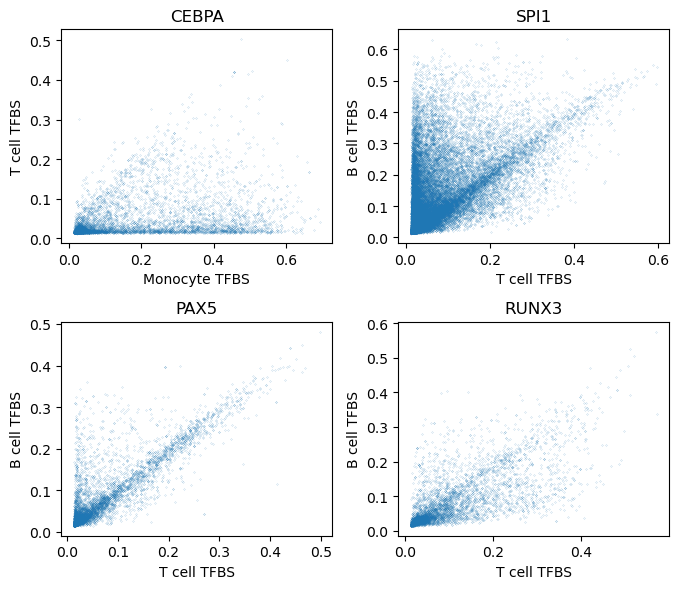

In [211]:
fig, ax = plt.subplots(2,2, figsize=(7,6))

scores = TFBS_scores.loc[TFBS_scores.TF.values == "CEBPA", :]
ax[0][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_Monocyte_{i}" for i in range(2)]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[0][0].set_xlabel("Monocyte TFBS")
ax[0][0].set_ylabel("T cell TFBS")
ax[0][0].set_title("CEBPA")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "SPI1", :]
ax[0][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[0][1].set_xlabel("T cell TFBS")
ax[0][1].set_ylabel("B cell TFBS")
ax[0][1].set_title("SPI1")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "PAX5", :]
ax[1][0].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[1][0].set_xlabel("T cell TFBS")
ax[1][0].set_ylabel("B cell TFBS")
ax[1][0].set_title("PAX5")
plt.tight_layout()

scores = TFBS_scores.loc[TFBS_scores.TF.values == "RUNX3", :]
ax[1][1].scatter(
    np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1), 
    np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1), s=0.01)
ax[1][1].set_xlabel("T cell TFBS")
ax[1][1].set_ylabel("B cell TFBS")
ax[1][1].set_title("RUNX3")

plt.show()

From the above results we clearly see that the model predicts elevated binding of CEBPA in monocytes compared to T cells, as well as higher binding of SPI1 in B cells compared to T cells, higher binding of PAX5 in B cells compared to T cells, and higher binding of RUNX in T cells compared to B cells. From the scatter plot, it was a bit hard to see whether RUNX overall gained binding or lost binding in T cells compared to B cells, so now we calculate the difference of binding at each site, and compare all sites where the absolute value of change is above a certain threhsold (let's do 0.05 for now), and then it becomes clear that RUNX binding is higher in T cells.

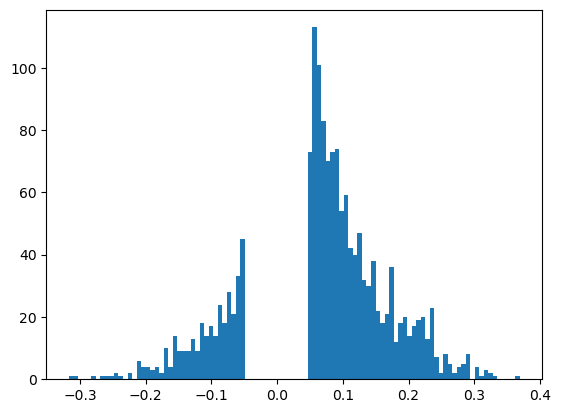

In [210]:
scores = TFBS_scores.loc[TFBS_scores.TF.values == "RUNX3", :]
Tcell_scores = np.mean(scores.loc[:, [f"TFBS_Tcell_{i}" for i in range(2)]], axis=1)
Bcell_scores = np.mean(scores.loc[:, [f"TFBS_Bcell_{i}" for i in range(2)]], axis=1)
diff = Tcell_scores - Bcell_scores
diff = diff[np.abs(diff) > 0.05]
plt.hist(diff, bins=100)
plt.show()

We hope this tutorial is helpful for you and if you run into any issues please feel free to open a GitHub issue at https://github.com/buenrostrolab/scPrinter!